In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['product_id'] = buy_sessions['product_id'].astype(str)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
df = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
df['product_id'] = df['product_id'].astype(str)

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df=df.groupby(by=[pd.Grouper(key='date', freq='W'), pd.Grouper(key='product_id')]).sum()

In [5]:
df

amount
date       product_id        
2019-08-04 1002             3
           1003             0
           1004             0
           1005             0
           1006             1
...                       ...
2021-12-26 1310             0
           1311             0
           1312             0
           1313             0
           1314             0

[24822 rows x 1 columns]

In [6]:
products = pd.read_json("../data/raw/second/products.jsonl", lines=True)
del products['product_name']
products['product_id']=products['product_id'].astype(str)
products.index=products['product_id']
df=df.join(products,on='product_id')

In [7]:
df.index = df.index.get_level_values(0)

In [8]:
df

,amount,product_id,category_path,price
date,,,,
2019-08-04,3,1002,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2019-08-04,0,1003,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
2019-08-04,0,1004,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,0,1005,Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2019-08-04,1,1006,Gry i konsole;Gry na konsole;Gry Xbox 360,59.90
...,...,...,...,...
2021-12-26,0,1310,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,79.99
2021-12-26,0,1311,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.99
2021-12-26,0,1312,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,99.90


In [9]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index.get_level_values(0)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.weekofyear
    del df['date']
    df=pd.get_dummies(df,columns=['category_path'])
    return df

In [10]:
split_date = pd.to_datetime('2021-09-01')
copy=df.copy()
train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

In [11]:
train=create_features(train)
test=create_features(test)

C:\Users\micha\AppData\Local\Temp/ipykernel_3256/583452908.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [12]:
def merge(df1, df2, col,col_name):
    
    df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col, right_index=False, sort=True,
             copy=True, indicator=False)
    
    df1 = df1.rename(columns={'amount_y':col_name})
    return df1

In [13]:
# train['monthly_avg'] = train.groupby(['product_id','month'])['amount'].transform('mean')
# train['weekly_avg'] = train.groupby(['product_id','weekofyear'])['amount'].transform('mean')

# monthly_avg = train.groupby(['product_id','month'])['amount'].mean().reset_index()
# weekly_avg = train.groupby(['product_id','weekofyear'])['amount'].mean().reset_index()

# test['copy_index'] = test.index

# test = merge(test, monthly_avg,['product_id','month'],'monthly_avg')
# test = test.rename(columns={'amount_x': 'amount'})

# test = merge(test, weekly_avg,['product_id','weekofyear'],'weekly_avg')
# test = test.rename(columns={'amount_x': 'amount'})

# test.index=test['copy_index']
# del test['copy_index']

[Text(0.5, 0, 'amount'),
 Text(1.5, 0, 'price'),
 Text(2.5, 0, 'quarter'),
 Text(3.5, 0, 'month'),
 Text(4.5, 0, 'year'),
 Text(5.5, 0, 'weekofyear'),
 Text(6.5, 0, 'category_path_Gry i konsole;Gry komputerowe'),
 Text(7.5, 0, 'category_path_Gry i konsole;Gry na konsole;Gry PlayStation3'),
 Text(8.5, 0, 'category_path_Gry i konsole;Gry na konsole;Gry Xbox 360'),
 Text(9.5, 0, 'category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne'),
 Text(10.5, 0, 'category_path_Komputery;Monitory;Monitory LCD'),
 Text(11.5, 0, 'category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV')]

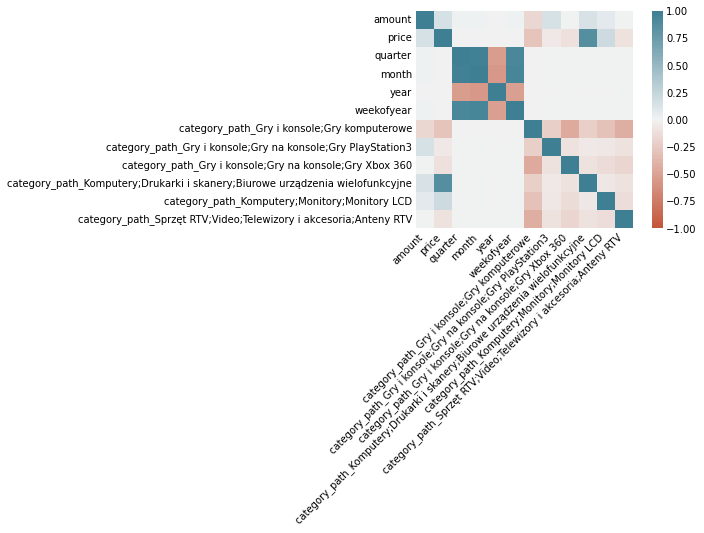

In [14]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [15]:
del train['product_id']
del test['product_id']

In [16]:
X_train=train.copy()
del X_train['amount']
y_train=train['amount']
              
X_test=test.copy()
del X_test['amount']
y_test=test['amount']

In [17]:
X_train

,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
date,,,,,,,,,,,
2019-08-04,2048.50,3,8,2019,31,0,0,0,1,0,0
2019-08-04,7639.00,3,8,2019,31,0,0,0,1,0,0
2019-08-04,49.99,3,8,2019,31,0,0,1,0,0,0
2019-08-04,49.99,3,8,2019,31,0,0,1,0,0,0
2019-08-04,59.90,3,8,2019,31,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-29,79.99,3,8,2021,34,0,0,0,0,0,1
2021-08-29,189.99,3,8,2021,34,0,0,0,0,0,1
2021-08-29,99.90,3,8,2021,34,0,0,0,0,0,1


In [18]:
X_test

,price,quarter,month,year,weekofyear,category_path_Gry i konsole;Gry komputerowe,category_path_Gry i konsole;Gry na konsole;Gry PlayStation3,category_path_Gry i konsole;Gry na konsole;Gry Xbox 360,category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,category_path_Komputery;Monitory;Monitory LCD,category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV
date,,,,,,,,,,,
2021-09-05,2048.50,3,9,2021,35,0,0,0,1,0,0
2021-09-05,7639.00,3,9,2021,35,0,0,0,1,0,0
2021-09-05,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,49.99,3,9,2021,35,0,0,1,0,0,0
2021-09-05,59.90,3,9,2021,35,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,79.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,189.99,4,12,2021,51,0,0,0,0,0,1
2021-12-26,99.90,4,12,2021,51,0,0,0,0,0,1


In [19]:
reg = xgb.XGBRegressor(n_estimators=1000,random_state=42)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

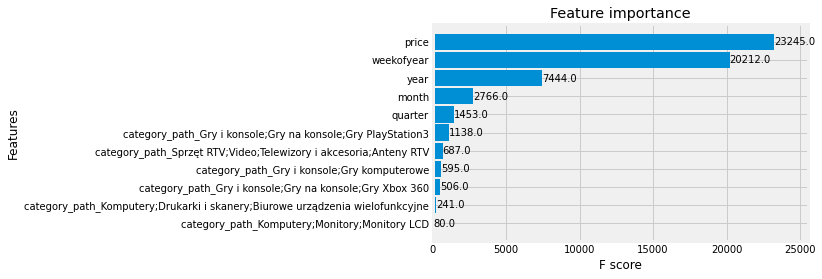

In [20]:
_ = plot_importance(reg, height=0.9)

In [27]:
X_test.columns.values

array(['price', 'quarter', 'month', 'year', 'weekofyear',
       'category_path_Gry i konsole;Gry komputerowe',
       'category_path_Gry i konsole;Gry na konsole;Gry PlayStation3',
       'category_path_Gry i konsole;Gry na konsole;Gry Xbox 360',
       'category_path_Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne',
       'category_path_Komputery;Monitory;Monitory LCD',
       'category_path_Sprzęt RTV;Video;Telewizory i akcesoria;Anteny RTV'],
      dtype=object)

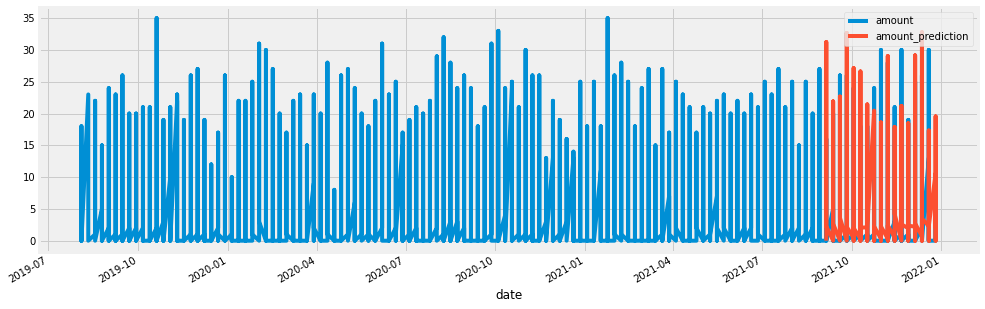

In [21]:
test['amount_prediction'] = reg.predict(X_test)
test['amount_prediction']=test['amount_prediction'].clip(lower=0)
df_all = pd.concat([train, test], sort=False)
_ = df_all[['amount','amount_prediction']].plot(figsize=(15, 5))

In [22]:
from sklearn.metrics import mean_squared_error as MSE
rmse=MSE(test['amount'], test['amount_prediction'],squared=False)

In [23]:
rmse

3.6244754618420623

In [24]:
import pickle
file_name = "xgboost_reg.pkl"

# save
pickle.dump(reg, open(f"../models/{file_name}", "wb"))

# load
xgb_model_loaded = pickle.load(open(f"../models/{file_name}", "rb"))
print(xgb_model_loaded)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
